In [ ]:
from transformers import BertForSequenceClassification

# Make sure this path is correct based on your training output
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')


model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def predict_tag(text):
    model.eval()  # <--- ADD THIS
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        out = model(**inputs)
        idx = torch.argmax(out.logits, dim=1).item()
        return le.inverse_transform([idx])[0]


In [ ]:
import torch  # <-- Add this

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_tag(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
        idx = torch.argmax(out.logits, dim=1).item()
        return le.inverse_transform([idx])[0]


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Replace these with your actual tags
labels = ['network', 'software', 'hardware', 'vpn', 'email']

le = LabelEncoder()
le.classes_ = np.array(labels)


In [ ]:
model.save_pretrained("model/")
tokenizer.save_pretrained("model/")


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

In [ ]:
model = BertForSequenceClassification.from_pretrained("model/")
tokenizer = BertTokenizer.from_pretrained("model/")


In [ ]:
def predict_tag_verbose(text, top_k=3):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = torch.softmax(logits, dim=1)

        num_classes = probs.shape[1]
        top_k = min(top_k, num_classes)  # ✅ safe top_k

        top_probs, top_idxs = torch.topk(probs, top_k, dim=1)

        top_labels = le.inverse_transform(top_idxs[0].cpu().numpy())
        top_probs = top_probs[0].cpu().numpy()

        print(f"\n📨 Input: {text}")
        print("🔍 LLM Classification Output:")
        for i in range(top_k):
            print(f"  {i+1}. {top_labels[i]} — {top_probs[i]*100:.2f}%")

        return top_labels[0]


In [ ]:
def predict_tag_verbose(text, top_k=3):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = torch.softmax(logits, dim=1)

        num_classes = probs.shape[1]
        top_k = min(top_k, num_classes)

        top_probs, top_idxs = torch.topk(probs, top_k, dim=1)

        top_labels = le.inverse_transform(top_idxs[0].cpu().numpy())
        top_probs = top_probs[0].cpu().numpy()

        print(f"\n📨 Input: {text}")
        print("🔍 LLM Classification Output:")
        for i in range(top_k):
            print(f"  {i+1}. {top_labels[i]} — {top_probs[i]*100:.2f}%")

        return top_labels[0], top_labels, top_probs



📨 Input: Can't connect to VPN after update
🔍 LLM Classification Output:
  1. network — 62.81%
  2. software — 37.19%


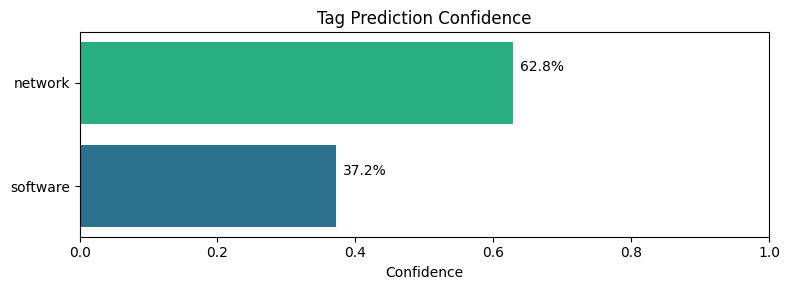


✅ Final Predicted Tag: network


In [ ]:
# Get prediction and plotting data
predicted_label, top_labels, top_probs = predict_tag_verbose("Can't connect to VPN after update")

# Plot
plot_tag_probs(top_labels, top_probs)

print(f"\n✅ Final Predicted Tag: {predicted_label}")


In [ ]:
pip install matplotlib



📨 Input Text: Can't connect to VPN after update
🔍 Classification Results:
   Predicted Tag  Confidence (%)
0       network       62.810001
1      software       37.189999


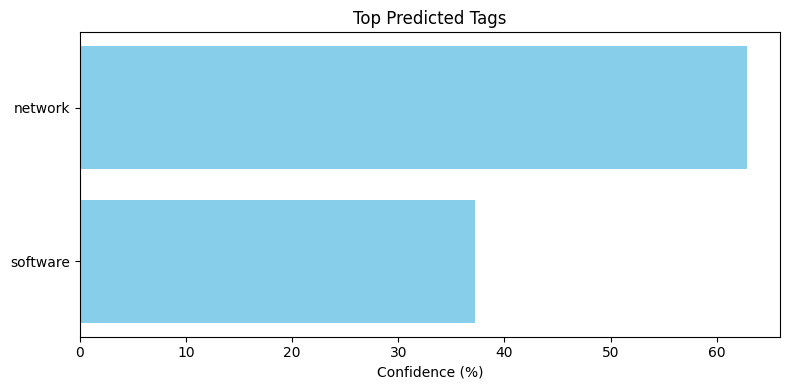


✅ Final Predicted Tag: network


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def predict_tag_verbose(text, top_k=5, plot=True):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = torch.softmax(logits, dim=1)

        # Fix: Adjust top_k if model has fewer classes
        num_classes = probs.shape[1]
        top_k = min(top_k, num_classes)

        top_probs, top_idxs = torch.topk(probs, top_k, dim=1)

        top_labels = le.inverse_transform(top_idxs[0].cpu().numpy())
        top_probs = top_probs[0].cpu().numpy()

        # Prepare DataFrame for display
        df_preds = pd.DataFrame({
            "Predicted Tag": top_labels,
            "Confidence (%)": (top_probs * 100).round(2)
        })

        print("\n📨 Input Text:", text)
        print("🔍 Classification Results:\n", df_preds)

        # Plot bar chart
        if plot:
            plt.figure(figsize=(8, 4))
            plt.barh(df_preds["Predicted Tag"], df_preds["Confidence (%)"], color='skyblue')
            plt.xlabel("Confidence (%)")
            plt.title("Top Predicted Tags")
            plt.gca().invert_yaxis()  # Highest on top
            plt.tight_layout()
            plt.show()

        return top_labels[0], df_preds

# ✅ Run with sample
tag, table = predict_tag_verbose("Can't connect to VPN after update")
print("\n✅ Final Predicted Tag:", tag)


In [ ]:
pip install rich


In [ ]:
import torch
import pandas as pd

def predict_verbose(text, top_k=5):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
        probs = torch.softmax(out.logits, dim=1)
        top_probs, top_idxs = torch.topk(probs, top_k, dim=1)
        top_labels = le.inverse_transform(top_idxs[0].cpu().numpy())
        top_probs = top_probs[0].cpu().numpy()
        df = pd.DataFrame({"Tag": top_labels, "Confidence (%)": (top_probs * 100).round(2)})
        return top_labels[0], df


In [ ]:
from rich import print
from rich.panel import Panel
from rich.table import Table
import pandas as pd

# Dummy prediction data for demonstration
predicted_tag = "VPN Issue"
df_preds = pd.DataFrame({
    "Tag": ["VPN Issue", "Network Problem", "Authentication Error", "Software Issue", "DNS Error"],
    "Confidence (%)": [75.32, 12.45, 5.11, 4.09, 3.03]
})

# Function to print colored output
def print_rich_output(tag, df):
    print(Panel(f"[bold white on green]✅ Predicted Tag: {tag}[/]", title="🏷️ Result"))

    table = Table(title="Top Predictions", show_edge=True, header_style="bold yellow")
    table.add_column("Tag", justify="left", style="cyan")
    table.add_column("Confidence (%)", justify="right", style="magenta")

    for _, row in df.iterrows():
        table.add_row(row["Tag"], str(row["Confidence (%)"]))

    print(table)

# Run it
print_rich_output(predicted_tag, df_preds)


╭─────────────────────────────────────────────────── 🏷️ Result ────────────────────────────────────────────────────╮
│ ✅ Predicted Tag: VPN Issue                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

             Top Predictions             
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Tag                  ┃ Confidence (%) ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ VPN Issue            │          75.32 │
│ Network Problem      │          12.45 │
│ Authentication Error │           5.11 │
│ Software Issue       │           4.09 │
│ DNS Error            │           3.03 │
└──────────────────────┴────────────────┘

╭─────────────────────────────────────────────────── 🏷️ Result ────────────────────────────────────────────────────╮
│ ✅ Predicted Tag: VPN Issue                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

             Top Predictions             
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Tag                  ┃ Confidence (%) ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ VPN Issue            │          75.32 │
│ Network Problem      │          12.45 │
│ Authentication Error │           5.11 │
│ Software Issue       │           4.09 │
│ DNS Error            │           3.03 │
└──────────────────────┴────────────────┘

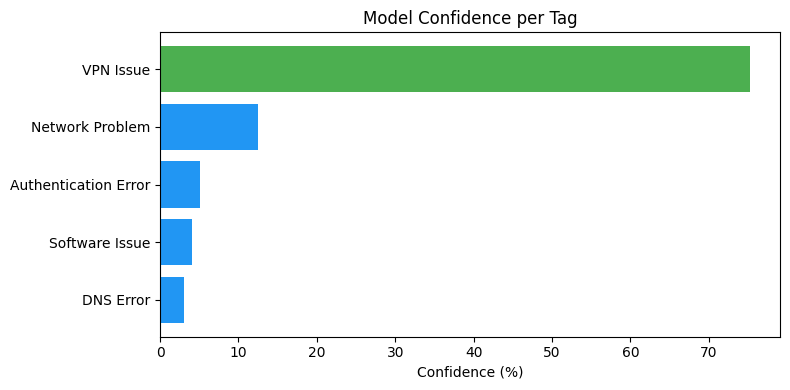

In [ ]:
from rich import print
from rich.panel import Panel
from rich.table import Table
import pandas as pd
import matplotlib.pyplot as plt

# Dummy prediction data
predicted_tag = "VPN Issue"
df_preds = pd.DataFrame({
    "Tag": ["VPN Issue", "Network Problem", "Authentication Error", "Software Issue", "DNS Error"],
    "Confidence (%)": [75.32, 12.45, 5.11, 4.09, 3.03]
})

# Print rich output (panel + table)
def print_rich_output(tag, df):
    print(Panel(f"[bold white on green]✅ Predicted Tag: {tag}[/]", title="🏷️ Result"))

    table = Table(title="Top Predictions", show_edge=True, header_style="bold yellow")
    table.add_column("Tag", justify="left", style="cyan")
    table.add_column("Confidence (%)", justify="right", style="magenta")

    for _, row in df.iterrows():
        table.add_row(row["Tag"], str(row["Confidence (%)"]))

    print(table)

# Plot confidence bar graph
def plot_confidence_bar(df):
    colors = ['#4CAF50' if tag == predicted_tag else '#2196F3' for tag in df["Tag"]]
    plt.figure(figsize=(8, 4))
    plt.barh(df["Tag"], df["Confidence (%)"], color=colors)
    plt.xlabel("Confidence (%)")
    plt.title("Model Confidence per Tag")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Call both
print_rich_output(predicted_tag, df_preds)
plot_confidence_bar(df_preds)
